In [1]:
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

In [2]:
# initially train directory contains all 2000 images(both benign and melanoma)
TRAIN_DIR = 'C:/Users/PRADHUMN MUDGAL/Desktop/Skin_Cancer_Classification/train'
TEST_DIR = 'C:/Users/PRADHUMN MUDGAL/Desktop/Skin_Cancer_Classification/test'
IMG_SIZE = 50
LR = 1e-3
MODEL_NAME = 'skin_cancer-{}-{}.model'.format(LR, '2conv-basic')

In [3]:
# assigning label to each image in earlier train directory based on whether it is benign or malignant
def label_img(img):
    word_label = img.split('.')[-3]
    if word_label == 'beg': return [1,0]
    elif word_label == 'mal': return [0,1]

In [4]:
# storing image with its label
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    # shuffle the images in train directory
    np.save('train_data.npy', training_data)
    return training_data

In [5]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [6]:
train_data = create_train_data()

100%|██████████████████████████████████████████████████████████████████████████████| 2000/2000 [05:22<00:00,  6.20it/s]


In [11]:
print(train_data)

[[array([[131, 159, 141, ..., 174, 210, 169],
       [160, 162, 156, ..., 166, 209, 187],
       [160, 155, 154, ..., 175, 202, 198],
       ...,
       [195, 207, 172, ..., 158, 157, 161],
       [188, 213, 180, ..., 142, 162, 135],
       [184, 195, 201, ..., 166, 162, 142]], dtype=uint8), array([1, 0])], [array([[164, 165, 158, ..., 162, 164, 155],
       [163, 164, 167, ..., 163, 161, 155],
       [163, 164, 166, ..., 168, 163, 163],
       ...,
       [150, 163, 163, ..., 154, 156, 150],
       [158, 163, 159, ..., 148, 147, 150],
       [160, 164, 164, ..., 146, 145, 154]], dtype=uint8), array([1, 0])], [array([[195, 196, 196, ..., 189, 192, 188],
       [194, 196, 202, ..., 195, 195, 189],
       [195, 196, 199, ..., 199, 188, 187],
       ...,
       [192, 197, 204, ..., 199, 199, 192],
       [190, 196, 200, ..., 195, 195, 189],
       [191, 195, 198, ..., 197, 195, 186]], dtype=uint8), array([1, 0])], [array([[170, 170, 169, ..., 168, 172, 170],
       [169, 169, 171, ..., 17

       [ 1,  1,  1, ...,  9,  2,  1]], dtype=uint8), array([0, 1])]]


In [7]:
import tensorflow as tf
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
tf.reset_default_graph()
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)
curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [14]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

In [15]:
train = train_data[:-500]
test = train_data[-500:]

In [16]:
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

In [18]:
model.fit({'input': X}, {'targets': Y}, n_epoch=20, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

model.save(MODEL_NAME)

Training Step: 959  | total loss: 0.33835 | time: 7.635s
| Adam | epoch: 040 | loss: 0.33835 - acc: 0.8556 -- iter: 1472/1500
Training Step: 960  | total loss: 0.34637 | time: 9.031s
| Adam | epoch: 040 | loss: 0.34637 - acc: 0.8498 | val_loss: 0.51465 - val_acc: 0.8160 -- iter: 1500/1500
--
INFO:tensorflow:C:\Python35\Scripts\skin_cancer-0.001-2conv-basic.model is not in all_model_checkpoint_paths. Manually adding it.


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 69.64it/s]


Prediction Result:


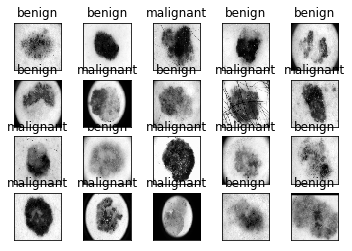

In [20]:
import matplotlib.pyplot as plt
test_data = process_test_data()
fig=plt.figure()
print("Prediction Result:")
for num,data in enumerate(test_data[:20]):
    
    img_num = data[1]
    img_data = data[0]
    y = fig.add_subplot(4,5,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='malignant'
    else: str_label='benign'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
    
plt.show()

In [21]:
Y_true=[i[1] for i in test]

In [22]:
Y_pred=[]
for num,data in enumerate(test):
    img_data = data[0]
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out = model.predict([data])[0]
    Y_pred.append(model_out)

In [26]:
print(Y_pred)
for data in (Y_pred):
    if data[0]>0.5: data[0]=int(1)
    else: data[0]=int(0)
    if data[1]>0.5: data[1]=int(1)
    else: data[1]=int(0)

[array([0.7478136, 0.2521864], dtype=float32), array([0.9337659 , 0.06623413], dtype=float32), array([0.9398315, 0.0601685], dtype=float32), array([0.75194687, 0.24805313], dtype=float32), array([0.96130943, 0.03869054], dtype=float32), array([0.90520287, 0.09479711], dtype=float32), array([0.9689827 , 0.03101738], dtype=float32), array([0.7494296 , 0.25057045], dtype=float32), array([0.8017504 , 0.19824962], dtype=float32), array([0.8151835 , 0.18481642], dtype=float32), array([0.9696876 , 0.03031248], dtype=float32), array([0.95147026, 0.0485297 ], dtype=float32), array([0.65667367, 0.34332636], dtype=float32), array([0.8897658 , 0.11023419], dtype=float32), array([0.86657965, 0.13342032], dtype=float32), array([0.9655105 , 0.03448953], dtype=float32), array([0.95133793, 0.04866207], dtype=float32), array([0.89561063, 0.10438938], dtype=float32), array([0.9495208 , 0.05047921], dtype=float32), array([0.6312886 , 0.36871147], dtype=float32), array([0.7693809 , 0.23061909], dtype=float

In [27]:
print(Y_pred)

[array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([0., 1.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([1., 0.], dtype=float32), array([

In [28]:
from sklearn.metrics import confusion_matrix
y_true=[]
y_pred=[]
for data in (Y_true):
    if(data[0]==1 and data[1]==0):
        y_true.append(1)
    else: y_true.append(0)

for data in (Y_pred):
    if(data[0]==1 and data[1]==0):
        y_pred.append(1)
    else: y_pred.append(0)
        

cm=confusion_matrix(y_true, y_pred)

In [29]:
print("Confusion Matrix of Melonoma")
print("-----------------------------")
print("          Benign | Malignant")
for i in (1,0):
    if i==1: print("Benign   |",end=' ')
    else: print("Malignant|",end=' ') 
    for j in (1,0):
        print(cm[i][j],end='      ') 
    print()

Confusion Matrix of Melonoma
-----------------------------
          Benign | Malignant
Benign   | 398      14      
Malignant| 78      10      


In [30]:
a=cm[1][1]
b=cm[1][0]
c=cm[0][1]
d=cm[0][0]

In [31]:
print("Precision and Recall for Benign Class")
print("---------------------------------------")
print("Precision:",end=' ')
print(a/(a+c))
print("Recall:",end=' ')
print(a/(a+b))

Precision and Recall for Benign Class
---------------------------------------
Precision: 0.8361344537815126
Recall: 0.9660194174757282


In [32]:
print("Precision and Recall for Malignant Class")
print("---------------------------------------")
print("Precision:",end=' ')
print(b/(b+d))
print("Recall:",end=' ')
print(b/(a+b))

Precision and Recall for Malignant Class
---------------------------------------
Precision: 0.5833333333333334
Recall: 0.03398058252427184
